In [1]:
import numpy as np
import nibabel as nib
import osmosis.model.isotropic as mdm
import osmosis.utils as ozu 
import dsitool as dst
import matplotlib 
import osmosis.viz.mpl as viz
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}
matplotlib.rc('font', **font)

%pylab inline
np.set_printoptions(threshold=np.nan)


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.kernel.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


/home/qytian/usr/local/lib/python2.7/site-packages/osmosis/model/base.py:18: UserWarning: Could not import numexpr. Get it! 
  warnings.warn(e_s)


In [2]:
files_cv = np.array(['DSI17_exvivo_wm', 'DSI11_invivo_wm'])
models = [mdm.single_exp_rs, mdm.bi_exp_rs, mdm.single_exp_nf_rs]
labels = ['mono-exp', 'bi-exp', 'mono-exp + noise floor']
colors = ['r', 'g', 'c']

Fitting TensorModel params using dipy
Fitting TensorModel params using dipy
Fitting TensorModel params using dipy
[ 0.09861617  0.0636744   0.06503008]

/home/qytian/usr/local/lib/python2.7/site-packages/osmosis/model/base.py:250: UserWarning: DWI data generated from array. Affine will be set to np.eye(4)
  warnings.warn(w_s)
/home/qytian/Canopy/appdata/canopy-1.0.3.1262.rh5-x86_64/lib/python2.7/site-packages/matplotlib/font_manager.py:1224: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


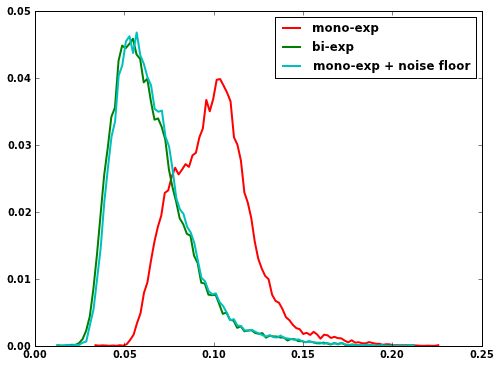

In [3]:
for ii in np.arange(files_cv.shape[0]):
    filename = files_cv[ii]
    
    data = dst.loaddata(filename);
    data = data.astype(float)
    #data = data[:, :, 0:2, :];
    
    gtab = dst.loadgtab(filename);
    bvals = gtab.bvals
    bvecs = gtab.bvecs
    
    mask = np.ones((data.shape[0], data.shape[1], data.shape[2])) # this mask covers the entire ROI
    mask = mask > 0.5
    
    predictions = []
    for isotropic_model, label in zip(models, labels):
        _, this_predict = mdm.kfold_xval_MD_mod(data, bvals, bvecs.T, mask, isotropic_model, 10, signal = "relative_signal")
        predictions.append(this_predict)
    
    rmse = []
    data_flat = data[np.where(mask)]    
    for prediction in predictions:
        rmse.append([])
        for vox in range(prediction.shape[0]):
            rmse[-1].append(ozu.rmse(data_flat[vox, 1:]/data_flat[vox,0], prediction[vox]))
    
    print(np.mean(rmse, axis=-1)) # display the mean RMSE for the three models over all WM voxels 
    np.save('results/' + filename + '_rmse', rmse);
    
    fig = figure();
    fig.set_size_inches([8, 6])
    
    for r, l, c in zip(rmse, labels, colors):
        hist = np.histogram(r, bins=100, density=True)
        plot(hist[1][1:], hist[0]/hist[0].sum(), label=l, color=c, linewidth=2)
            
    legend()
    rmsename = 'figure/figure3/' + filename + '_rmse.png';
    fig.savefig(rmsename, dpi=600)